In [2]:
import time
import logging
from functools import wraps
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn
import os

In [3]:
# Configuración básica de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [4]:
def timer_decorator(func):
    """Decorador para medir el tiempo de ejecución de una función."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        logger.info(f"Función {func.__name__} ejecutada en {end_time - start_time:.2f} segundos")
        return result
    return wrapper


def log_decorator(func):
    """Decorador para registrar la entrada y salida de una función."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        logger.info(f"Llamando a la función: {func.__name__}")
        result = func(*args, **kwargs)
        logger.info(f"Función {func.__name__} completada")
        return result
    return wrapper


def error_handler(func):
    """Decorador para manejar y registrar errores."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            logger.error(f"Error en la función {func.__name__}: {str(e)}")
            raise
    return wrapper

In [5]:
# Ejemplo de uso:
@timer_decorator
@log_decorator
@error_handler
def example_function(x, y):
    """Una función de ejemplo para demostrar los decoradores."""
    logger.info(f"Operando con {x} y {y}")
    result = x / y
    return result

In [6]:
# Uso de la función de ejemplo:
try:
    result = example_function(10, 2)
    print(f"Resultado: {result}")
    result = example_function(10, 0)  # Esto generará un error
except Exception as e:
    print(f"Se capturó una excepción: {e}")

2024-08-10 16:49:01,351 - __main__ - INFO - Llamando a la función: example_function
2024-08-10 16:49:01,352 - __main__ - INFO - Operando con 10 y 2
2024-08-10 16:49:01,353 - __main__ - INFO - Función example_function completada
2024-08-10 16:49:01,353 - __main__ - INFO - Función example_function ejecutada en 0.00 segundos
2024-08-10 16:49:01,354 - __main__ - INFO - Llamando a la función: example_function
2024-08-10 16:49:01,354 - __main__ - INFO - Operando con 10 y 0
2024-08-10 16:49:01,355 - __main__ - ERROR - Error en la función example_function: division by zero


Resultado: 5.0
Se capturó una excepción: division by zero


In [7]:
class BankData:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None

    @timer_decorator
    @error_handler
    @log_decorator
    def load_data(self):
        """Carga los datos del archivo CSV."""
        try:
            self.data = pd.read_csv(self.file_path)
            print(f"Datos cargados exitosamente. Shape: {self.data.shape}")
        except Exception as e:
            print(f"Error al cargar los datos: {e}")

    @timer_decorator
    @error_handler
    @log_decorator
    def get_info(self):
        """Obtiene información básica del dataset."""
        if self.data is not None:
            print(self.data.info())
        else:
            print("Los datos no han sido cargados aún.")

    @timer_decorator
    @error_handler
    @log_decorator
    def check_nulls(self):
        """Verifica y muestra la cantidad de valores nulos por columna."""
        if self.data is not None:
            null_counts = self.data.isnull().sum()
            print("Conteo de valores nulos por columna:")
            print(null_counts)
        else:
            print("Los datos no han sido cargados aún.")

    @timer_decorator
    @error_handler
    @log_decorator
    def handle_nulls(self, strategy='drop'):
        """
        Maneja los valores nulos en el dataset.

        :param strategy: Estrategia para manejar nulos ('drop' o 'impute')
        """
        if self.data is not None:
            if strategy == 'drop':
                self.data.dropna(inplace=True)
                print("Filas con valores nulos eliminadas.")
            elif strategy == 'impute':
                for column in self.data.columns:
                    if self.data[column].dtype == 'object':
                        self.data[column].fillna(self.data[column].mode()[0], inplace=True)
                    else:
                        self.data[column].fillna(self.data[column].mean(), inplace=True)
                print("Valores nulos imputados.")
            else:
                print("Estrategia no reconocida. Use 'drop' o 'impute'.")
        else:
            print("Los datos no han sido cargados aún.")

In [8]:
# Ejemplo de uso:
bank_data = BankData("../data/raw_data/Churn_Modelling.csv")
bank_data.load_data()

2024-08-10 16:49:02,655 - __main__ - INFO - Llamando a la función: load_data
2024-08-10 16:49:02,673 - __main__ - INFO - Función load_data completada
2024-08-10 16:49:02,673 - __main__ - INFO - Función load_data ejecutada en 0.02 segundos


Datos cargados exitosamente. Shape: (10000, 14)


In [9]:
bank_data.get_info()

2024-08-10 16:49:05,943 - __main__ - INFO - Llamando a la función: get_info
2024-08-10 16:49:05,955 - __main__ - INFO - Función get_info completada
2024-08-10 16:49:05,956 - __main__ - INFO - Función get_info ejecutada en 0.01 segundos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


In [10]:
bank_data.check_nulls()

2024-08-10 16:49:07,139 - __main__ - INFO - Llamando a la función: check_nulls
2024-08-10 16:49:07,143 - __main__ - INFO - Función check_nulls completada
2024-08-10 16:49:07,143 - __main__ - INFO - Función check_nulls ejecutada en 0.00 segundos


Conteo de valores nulos por columna:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [11]:
# Vemos el dataset original
bank_data.data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [12]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

class DataPreparation:
    def __init__(self, data):
        self.data = data.copy()
        self.numeric_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
        self.categorical_columns = ['Geography', 'Gender']
        self.binary_columns = ['HasCrCard', 'IsActiveMember']

    @timer_decorator
    @error_handler
    @log_decorator
    def remove_irrelevant_columns(self):
        """Elimina columnas que no son relevantes para el análisis si existen."""
        columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
        existing_columns = [col for col in columns_to_drop if col in self.data.columns]
        if existing_columns:
            self.data.drop(columns=existing_columns, inplace=True)
        return self

    @timer_decorator
    @error_handler
    @log_decorator
    def handle_missing_values(self):
        """Maneja los valores faltantes en el conjunto de datos."""
        num_imputer = SimpleImputer(strategy='mean')
        self.data[self.numeric_columns] = num_imputer.fit_transform(self.data[self.numeric_columns])
        
        cat_imputer = SimpleImputer(strategy='most_frequent')
        self.data[self.categorical_columns] = cat_imputer.fit_transform(self.data[self.categorical_columns])
        
        return self

    @timer_decorator
    @error_handler
    @log_decorator
    def encode_categorical_variables(self):
        """Codifica las variables categóricas."""
        le = LabelEncoder()
        for col in self.categorical_columns:
            self.data[col] = le.fit_transform(self.data[col])
        return self

    @timer_decorator
    @error_handler
    @log_decorator
    def normalize_numeric_features(self):
        """Normaliza las características numéricas."""
        scaler = StandardScaler()
        self.data[self.numeric_columns] = scaler.fit_transform(self.data[self.numeric_columns])
        return self

    @timer_decorator
    @error_handler
    @log_decorator
    def create_binary_flags(self):
        """Crea flags binarios para algunas características."""
        self.data['HasBalance'] = (self.data['Balance'] > 0).astype(int)
        self.data['IsOlderThan40'] = (self.data['Age'] > 40).astype(int)
        self.binary_columns.extend(['HasBalance', 'IsOlderThan40'])
        return self

    @timer_decorator
    @error_handler
    @log_decorator
    def prepare_data(self):
        """Ejecuta todos los pasos de preparación de datos."""
        return (self.remove_irrelevant_columns()
                    .handle_missing_values()
                    .encode_categorical_variables()
                    .normalize_numeric_features()
                    .create_binary_flags())

    @timer_decorator
    @error_handler
    @log_decorator
    def get_prepared_data(self):
        """Devuelve los datos preparados."""
        return self.data

In [13]:
# Ejemplo de uso:
data_prep = DataPreparation(bank_data.data)
prepared_data = data_prep.prepare_data().get_prepared_data()

2024-08-10 16:49:10,170 - __main__ - INFO - Llamando a la función: prepare_data
2024-08-10 16:49:10,171 - __main__ - INFO - Llamando a la función: remove_irrelevant_columns
2024-08-10 16:49:10,173 - __main__ - INFO - Función remove_irrelevant_columns completada
2024-08-10 16:49:10,173 - __main__ - INFO - Función remove_irrelevant_columns ejecutada en 0.00 segundos
2024-08-10 16:49:10,173 - __main__ - INFO - Llamando a la función: handle_missing_values
2024-08-10 16:49:10,183 - __main__ - INFO - Función handle_missing_values completada
2024-08-10 16:49:10,183 - __main__ - INFO - Función handle_missing_values ejecutada en 0.01 segundos
2024-08-10 16:49:10,183 - __main__ - INFO - Llamando a la función: encode_categorical_variables
2024-08-10 16:49:10,186 - __main__ - INFO - Función encode_categorical_variables completada
2024-08-10 16:49:10,186 - __main__ - INFO - Función encode_categorical_variables ejecutada en 0.00 segundos
2024-08-10 16:49:10,187 - __main__ - INFO - Llamando a la func

In [14]:
# Vemos el dataset preparado
prepared_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,HasBalance,IsOlderThan40
0,-0.326221,0,0,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,1,0,0
1,-0.440036,2,0,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,0,1,0
2,-1.536794,0,0,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,1,1,0
3,0.501521,0,0,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,0,0,0
4,2.063884,2,0,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,0,1,0


In [15]:
# Guardamos el dataset preparado
prepared_data.to_csv("../data/processed_data/Churn_Modelling_Prepared.csv", index=False)

In [16]:
# Guardamos el objeto data_prep

import pickle

with open("../models/data_preparation.pkl", "wb") as f:
    pickle.dump(data_prep, f)

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class ExploratoryDataAnalysis:
    def __init__(self, data):
        self.data = data

    @timer_decorator
    @error_handler
    @log_decorator
    def plot_histograms(self, columns):
        """Genera histogramas para las columnas especificadas."""
        fig, axes = plt.subplots(len(columns), 1, figsize=(10, 5*len(columns)))
        for i, column in enumerate(columns):
            sns.histplot(self.data[column], ax=axes[i] if len(columns) > 1 else axes)
            axes[i].set_title(f'Distribución de {column}') if len(columns) > 1 else axes.set_title(f'Distribución de {column}')
        plt.tight_layout()
        plt.show()

    @timer_decorator
    @error_handler
    @log_decorator
    def plot_correlation_matrix(self):
        """Genera una matriz de correlación para las variables numéricas."""
        corr = self.data.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title('Matriz de Correlación')
        plt.show()

    @timer_decorator
    @error_handler
    @log_decorator
    def plot_boxplots(self, columns):
        """Genera boxplots para las columnas especificadas."""
        fig, axes = plt.subplots(len(columns), 1, figsize=(10, 5*len(columns)))
        for i, column in enumerate(columns):
            sns.boxplot(x=self.data[column], ax=axes[i] if len(columns) > 1 else axes)
            axes[i].set_title(f'Boxplot de {column}') if len(columns) > 1 else axes.set_title(f'Boxplot de {column}')
        plt.tight_layout()
        plt.show()

    @timer_decorator
    @error_handler
    @log_decorator
    def print_summary_statistics(self):
        """Imprime estadísticas resumidas del dataset."""
        print(self.data.describe())

    @timer_decorator
    @error_handler
    @log_decorator
    def plot_target_distribution(self, target_column):
        """Genera un gráfico de barras para la distribución de la variable objetivo."""
        plt.figure(figsize=(10, 6))
        sns.countplot(x=self.data[target_column])
        plt.title(f'Distribución de {target_column}')
        plt.show()

In [18]:
# Ejemplo de uso:

eda = ExploratoryDataAnalysis(prepared_data)

2024-08-10 16:49:16,332 - __main__ - INFO - Llamando a la función: plot_histograms


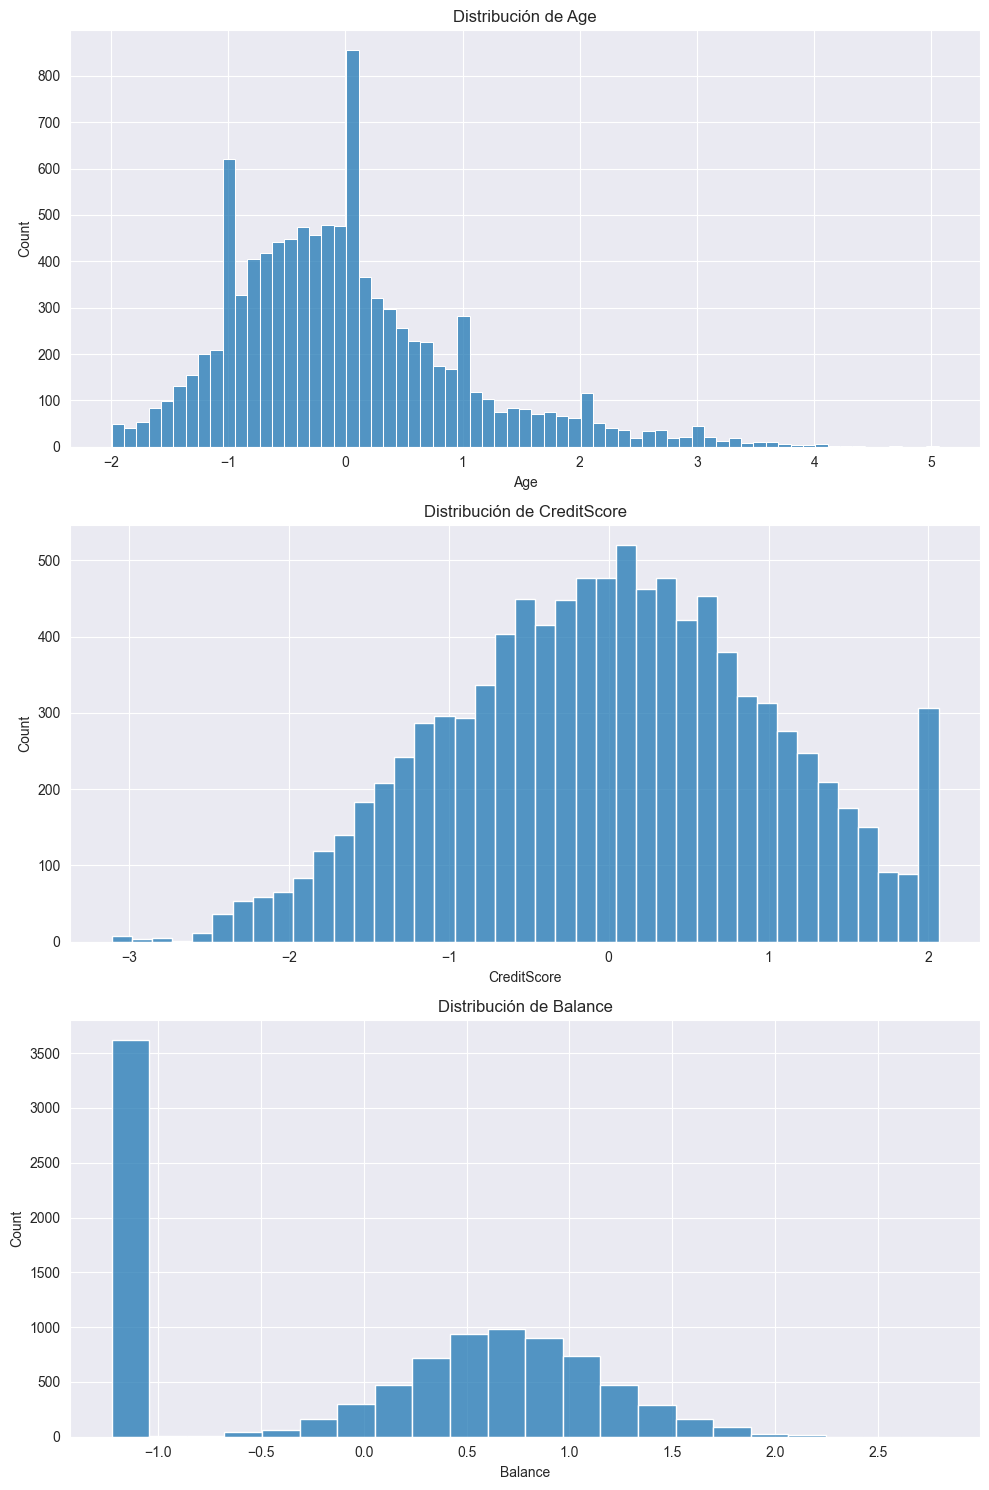

2024-08-10 16:49:17,052 - __main__ - INFO - Función plot_histograms completada
2024-08-10 16:49:17,057 - __main__ - INFO - Función plot_histograms ejecutada en 0.73 segundos


In [19]:
eda.plot_histograms(['Age', 'CreditScore', 'Balance'])

2024-08-10 16:49:17,801 - __main__ - INFO - Llamando a la función: plot_correlation_matrix


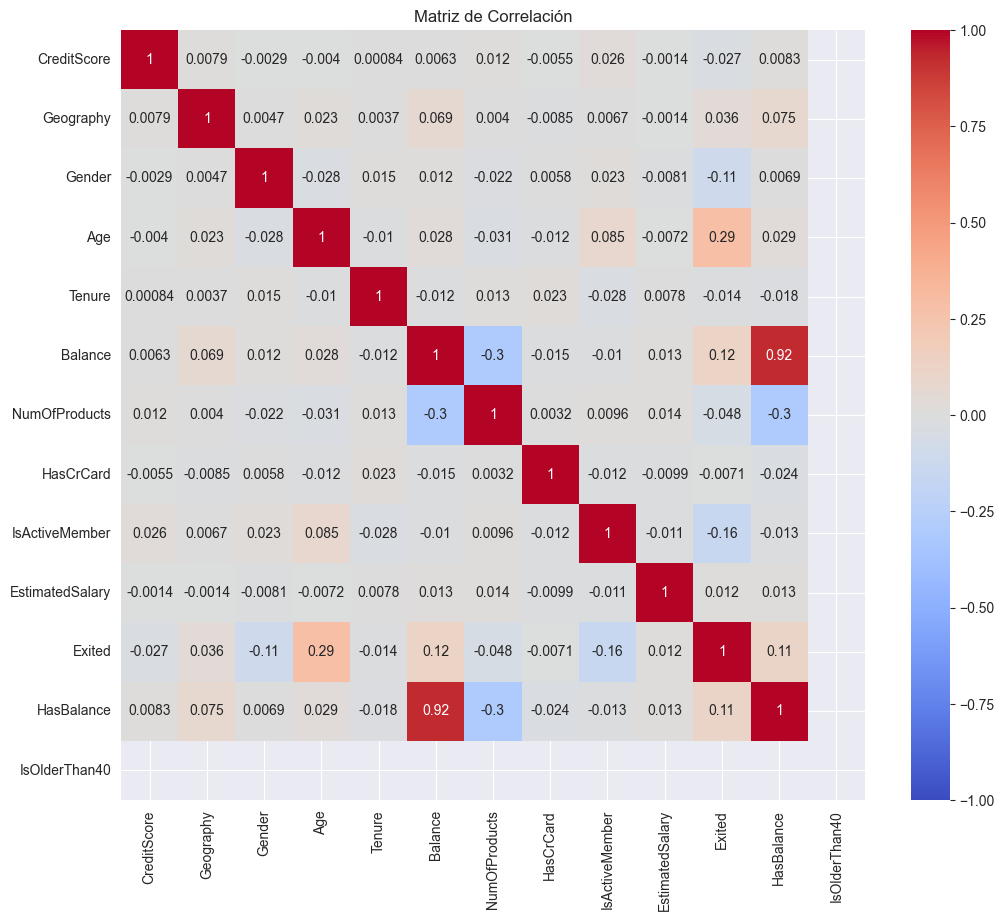

2024-08-10 16:49:18,112 - __main__ - INFO - Función plot_correlation_matrix completada
2024-08-10 16:49:18,113 - __main__ - INFO - Función plot_correlation_matrix ejecutada en 0.31 segundos


In [20]:
eda.plot_correlation_matrix()

2024-08-10 16:49:18,858 - __main__ - INFO - Llamando a la función: plot_boxplots


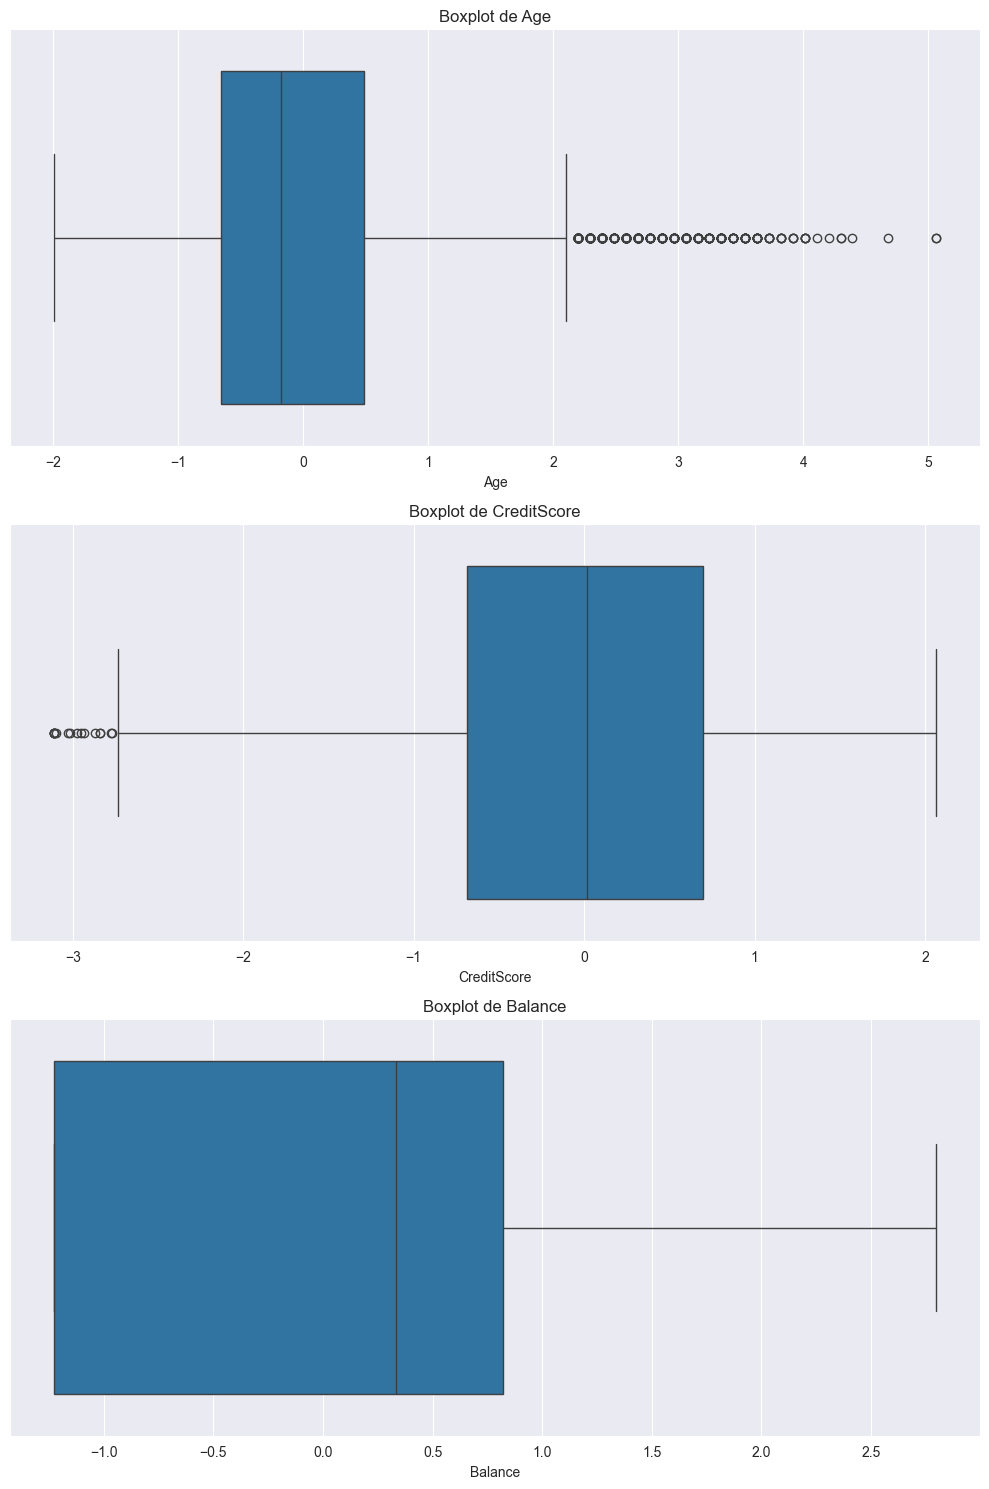

2024-08-10 16:49:19,123 - __main__ - INFO - Función plot_boxplots completada
2024-08-10 16:49:19,124 - __main__ - INFO - Función plot_boxplots ejecutada en 0.27 segundos


In [21]:
eda.plot_boxplots(['Age', 'CreditScore', 'Balance'])

In [22]:
eda.print_summary_statistics()

2024-08-10 16:49:20,112 - __main__ - INFO - Llamando a la función: print_summary_statistics
2024-08-10 16:49:20,123 - __main__ - INFO - Función print_summary_statistics completada
2024-08-10 16:49:20,124 - __main__ - INFO - Función print_summary_statistics ejecutada en 0.01 segundos


        CreditScore     Geography        Gender           Age        Tenure  \
count  1.000000e+04  10000.000000  10000.000000  1.000000e+04  1.000000e+04   
mean  -4.824585e-16      0.746300      0.545700  2.318146e-16 -1.078249e-16   
std    1.000050e+00      0.827529      0.497932  1.000050e+00  1.000050e+00   
min   -3.109504e+00      0.000000      0.000000 -1.994969e+00 -1.733315e+00   
25%   -6.883586e-01      0.000000      0.000000 -6.600185e-01 -6.959818e-01   
50%    1.522218e-02      0.000000      1.000000 -1.832505e-01 -4.425957e-03   
75%    6.981094e-01      1.000000      1.000000  4.842246e-01  6.871299e-01   
max    2.063884e+00      2.000000      1.000000  5.061197e+00  1.724464e+00   

            Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count  1.000000e+04   1.000000e+04  10000.00000    10000.000000   
mean  -6.252776e-17   1.634248e-17      0.70550        0.515100   
std    1.000050e+00   1.000050e+00      0.45584        0.499797   
min   -1.225848e+00 

2024-08-10 16:49:21,464 - __main__ - INFO - Llamando a la función: plot_target_distribution
2024-08-10 16:49:21,477 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-10 16:49:21,484 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


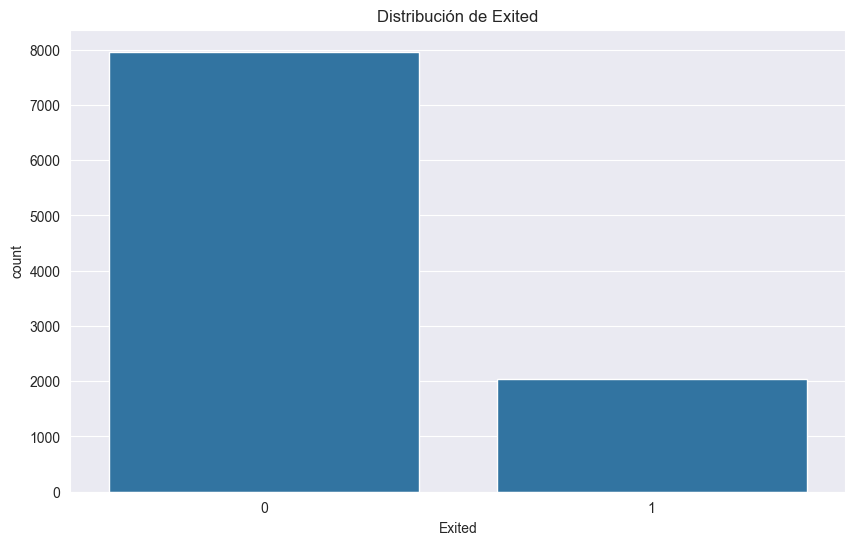

2024-08-10 16:49:21,545 - __main__ - INFO - Función plot_target_distribution completada
2024-08-10 16:49:21,545 - __main__ - INFO - Función plot_target_distribution ejecutada en 0.08 segundos


In [23]:
eda.plot_target_distribution('Exited')

In [24]:
class MixtureOfAgents(BaseEstimator, ClassifierMixin):
    def __init__(self, models=None, weights=None, experiment_name="MOA_Experiment", data_dir="../data"):
        self.models = models or []
        self.weights = weights
        self.classes_ = None
        self.experiment_name = experiment_name
        self.data_dir = data_dir
        mlflow.set_experiment(experiment_name)

    @timer_decorator
    @error_handler
    @log_decorator
    def add_model(self, model, weight=1.0):
        """Añade un modelo al conjunto."""
        self.models.append(model)
        if self.weights is None:
            self.weights = [1.0] * len(self.models)
        else:
            self.weights.append(weight)

    @timer_decorator
    @error_handler
    @log_decorator
    def split_and_save_data(self, X, y, test_size=0.2, val_size=0.2):
        """Divide los datos en conjuntos de entrenamiento, validación y prueba, y los guarda."""
        # Primera división: separar el conjunto de prueba
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
        
        # Segunda división: separar el conjunto de validación del de entrenamiento
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size_adjusted, stratify=y_train_val, random_state=42)

        # Crear directorios si no existen
        for dir_name in ['train', 'val', 'test']:
            os.makedirs(os.path.join(self.data_dir, dir_name), exist_ok=True)

        # Guardar los conjuntos de datos
        pd.concat([X_train, y_train], axis=1).to_csv(os.path.join(self.data_dir, 'train', 'train_data.csv'), index=False)
        pd.concat([X_val, y_val], axis=1).to_csv(os.path.join(self.data_dir, 'val', 'val_data.csv'), index=False)
        pd.concat([X_test, y_test], axis=1).to_csv(os.path.join(self.data_dir, 'test', 'test_data.csv'), index=False)

        return X_train, X_val, X_test, y_train, y_val, y_test

    @timer_decorator
    @error_handler
    @log_decorator
    def load_data(self, data_type='train'):
        """Carga los datos del directorio especificado."""
        file_path = os.path.join(self.data_dir, data_type, f'{data_type}_data.csv')
        data = pd.read_csv(file_path)
        y = data.pop('target')  # Asumimos que la columna objetivo se llama 'target'
        X = data
        return X, y

    @timer_decorator
    @error_handler
    @log_decorator
    def fit(self, X, y):
        """Entrena todos los modelos en el conjunto."""
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)

        with mlflow.start_run(run_name="MOA_Training"):
            for i, model in enumerate(self.models):
                with mlflow.start_run(run_name=f"Model_{i}_Training", nested=True):
                    model.fit(X, y)
                    mlflow.log_param(f"model_{i}", type(model).__name__)
                    mlflow.log_param(f"weight_{i}", self.weights[i])

            mlflow.log_param("n_models", len(self.models))
            mlflow.sklearn.log_model(self, "moa_model")

        return self

    @timer_decorator
    @error_handler
    @log_decorator
    def predict_proba(self, X):
        """Predice las probabilidades de clase para X."""
        check_is_fitted(self)
        X = check_array(X)

        predictions = []
        for model, weight in zip(self.models, self.weights):
            if hasattr(model, "predict_proba"):
                pred = model.predict_proba(X)
            else:
                pred = np.eye(len(self.classes_))[model.predict(X)]
            predictions.append(weight * pred)

        return np.sum(predictions, axis=0) / np.sum(self.weights)

    @timer_decorator
    @error_handler
    @log_decorator
    def predict(self, X):
        """Predice las etiquetas de clase para X."""
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

    @timer_decorator
    @error_handler
    @log_decorator
    def evaluate(self, X, y):
        """Evalúa el rendimiento del modelo."""
        y_pred = self.predict(X)
        metrics = {
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred, average='weighted'),
            'recall': recall_score(y, y_pred, average='weighted'),
            'f1': f1_score(y, y_pred, average='weighted')
        }

        with mlflow.start_run(run_name="MOA_Evaluation"):
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(metric_name, metric_value)

        return metrics

In [25]:
# Ejemplo de uso:
moa = MixtureOfAgents(experiment_name="Churn_Prediction_MOA")

In [26]:
moa.add_model(LogisticRegression(), weight=1.0)
moa.add_model(DecisionTreeClassifier(), weight=0.8)
moa.add_model(RandomForestClassifier(), weight=1.2)

2024-08-10 16:49:28,919 - __main__ - INFO - Llamando a la función: add_model
2024-08-10 16:49:28,919 - __main__ - INFO - Función add_model completada
2024-08-10 16:49:28,920 - __main__ - INFO - Función add_model ejecutada en 0.00 segundos
2024-08-10 16:49:28,920 - __main__ - INFO - Llamando a la función: add_model
2024-08-10 16:49:28,920 - __main__ - INFO - Función add_model completada
2024-08-10 16:49:28,921 - __main__ - INFO - Función add_model ejecutada en 0.00 segundos
2024-08-10 16:49:28,921 - __main__ - INFO - Llamando a la función: add_model
2024-08-10 16:49:28,921 - __main__ - INFO - Función add_model completada
2024-08-10 16:49:28,921 - __main__ - INFO - Función add_model ejecutada en 0.00 segundos


In [27]:
# Dividir los datos

X = prepared_data.drop('Exited', axis=1)
y = prepared_data['Exited']
X_train, X_val, X_test, y_train, y_val, y_test = moa.split_and_save_data(X, y)

2024-08-10 16:49:33,678 - __main__ - INFO - Llamando a la función: split_and_save_data
2024-08-10 16:49:33,756 - __main__ - INFO - Función split_and_save_data completada
2024-08-10 16:49:33,757 - __main__ - INFO - Función split_and_save_data ejecutada en 0.08 segundos


In [28]:
# Entrenar el modelo
moa.fit(X_train, y_train)

2024-08-10 16:49:34,572 - __main__ - INFO - Llamando a la función: fit
2024/08/10 16:49:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024-08-10 16:49:37,460 - __main__ - INFO - Función fit completada
2024-08-10 16:49:37,460 - __main__ - INFO - Función fit ejecutada en 2.89 segundos


MixtureOfAgents(experiment_name='Churn_Prediction_MOA',
                models=[LogisticRegression(), DecisionTreeClassifier(),
                        RandomForestClassifier()],
                weights=[1.0, 0.8, 1.2])

In [29]:
# Evaluar en el conjunto de validación
val_evaluation = moa.evaluate(X_val, y_val)
print("Evaluación en validación:", val_evaluation)

2024-08-10 16:49:39,766 - __main__ - INFO - Llamando a la función: evaluate
2024-08-10 16:49:39,767 - __main__ - INFO - Llamando a la función: predict
2024-08-10 16:49:39,767 - __main__ - INFO - Llamando a la función: predict_proba
2024-08-10 16:49:39,794 - __main__ - INFO - Función predict_proba completada
2024-08-10 16:49:39,795 - __main__ - INFO - Función predict_proba ejecutada en 0.03 segundos
2024-08-10 16:49:39,795 - __main__ - INFO - Función predict completada
2024-08-10 16:49:39,796 - __main__ - INFO - Función predict ejecutada en 0.03 segundos
2024-08-10 16:49:39,812 - __main__ - INFO - Función evaluate completada
2024-08-10 16:49:39,813 - __main__ - INFO - Función evaluate ejecutada en 0.05 segundos


Evaluación en validación: {'accuracy': 0.8455, 'precision': np.float64(0.8320701062399641), 'recall': np.float64(0.8455), 'f1': np.float64(0.8299176877890505)}


In [30]:
# Evaluar en el conjunto de prueba
test_evaluation = moa.evaluate(X_test, y_test)
print("Evaluación en prueba:", test_evaluation)

2024-08-10 16:49:42,795 - __main__ - INFO - Llamando a la función: evaluate
2024-08-10 16:49:42,796 - __main__ - INFO - Llamando a la función: predict
2024-08-10 16:49:42,797 - __main__ - INFO - Llamando a la función: predict_proba
2024-08-10 16:49:42,820 - __main__ - INFO - Función predict_proba completada
2024-08-10 16:49:42,820 - __main__ - INFO - Función predict_proba ejecutada en 0.02 segundos
2024-08-10 16:49:42,821 - __main__ - INFO - Función predict completada
2024-08-10 16:49:42,821 - __main__ - INFO - Función predict ejecutada en 0.03 segundos
2024-08-10 16:49:42,845 - __main__ - INFO - Función evaluate completada
2024-08-10 16:49:42,846 - __main__ - INFO - Función evaluate ejecutada en 0.05 segundos


Evaluación en prueba: {'accuracy': 0.8475, 'precision': np.float64(0.8346848383307078), 'recall': np.float64(0.8475), 'f1': np.float64(0.8338220851980025)}


In [31]:
# Guardar el modelo

mlflow.sklearn.save_model(moa, "../models/moa_model")

MlflowException: Path '../models/moa_model' already exists and is not empty

graph TD
    A[Datos de Entrada] --> B{Mixture of Agents}
    B --> |Distribuye datos| C[Modelo 1]
    B --> |Distribuye datos| D[Modelo 2]
    B --> |Distribuye datos| E[Modelo 3]
    C --> |Predicción 1| F{Agregador}
    D --> |Predicción 2| F
    E --> |Predicción 3| F
    F --> |Aplica pesos| G[Predicción Final]
    H[Pesos de Modelos] --> F

Explicación del diagrama:

Datos de Entrada: El proceso comienza con los datos de entrada, que son las características de los clientes bancarios en nuestro caso.
Mixture of Agents: Este es el núcleo de nuestro sistema. Recibe los datos de entrada y los distribuye a los diferentes modelos.
Modelos Individuales (Modelo 1, Modelo 2, Modelo 3): Cada uno de estos representa un modelo de aprendizaje automático diferente (por ejemplo, Regresión Logística, Árbol de Decisión, Bosque Aleatorio). Cada modelo procesa los datos y genera su propia predicción.
Predicciones Individuales: Cada modelo produce su propia predicción basada en los datos de entrada.
Agregador: Este componente recibe las predicciones de todos los modelos individuales.
Pesos de Modelos: Cada modelo tiene un peso asociado que determina su influencia en la predicción final. Estos pesos se aplican en el agregador.
Predicción Final: El agregador combina las predicciones individuales, aplicando los pesos correspondientes, para producir una predicción final.

El proceso funciona de la siguiente manera:

Los datos de entrada se pasan al MOA.
El MOA distribuye estos datos a cada uno de los modelos individuales.
Cada modelo procesa los datos y genera su propia predicción.
Estas predicciones individuales se envían al agregador.
El agregador aplica los pesos a cada predicción.
Se combinan las predicciones ponderadas para producir una predicción final.

La ventaja de este enfoque es que aprovecha las fortalezas de múltiples modelos. Algunos modelos pueden ser mejores en ciertos aspectos de la predicción, mientras que otros pueden capturar diferentes patrones en los datos. Al combinar sus predicciones, el MOA puede producir resultados más robustos y precisos que cualquier modelo individual.
Además, al ajustar los pesos, puedes dar más importancia a los modelos que funcionan mejor para tu conjunto de datos específico, mejorando aún más el rendimiento general del sistema.

In [32]:
import pandas as pd
import mlflow
import mlflow.pyfunc
import joblib
import numpy as np

class Prediction:
    def __init__(self, model_path, data_prep_path):
        self.model = self.load_model(model_path)
        self.data_prep = self.load_data_prep(data_prep_path)
        self.expected_columns = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 
                                 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
                                 'HasBalance', 'IsOlderThan40']

    @staticmethod
    def load_model(model_path):
        return mlflow.pyfunc.load_model(model_path)

    @staticmethod
    def load_data_prep(data_prep_path):
        return joblib.load(data_prep_path)

    def prepare_data(self, data):
        """Prepara los datos para la predicción."""
        data_prep_instance = self.data_prep.__class__(data)
        prepared_data = data_prep_instance.prepare_data().get_prepared_data()
        
        # Asegurarse de que todas las columnas esperadas estén presentes
        for col in self.expected_columns:
            if col not in prepared_data.columns:
                if col == 'HasBalance':
                    prepared_data[col] = (prepared_data['Balance'] > 0).astype(int)
                elif col == 'IsOlderThan40':
                    prepared_data[col] = (prepared_data['Age'] > 40).astype(int)
                else:
                    raise ValueError(f"Columna esperada '{col}' no está presente en los datos preparados")
        
        return prepared_data[self.expected_columns]

    def predict(self, data):
        """Realiza predicciones usando el modelo MOA."""
        prepared_data = self.prepare_data(data)
        return self.model.predict(prepared_data)

    def predict_proba(self, data):
        """Realiza predicciones de probabilidad usando el modelo MOA."""
        prepared_data = self.prepare_data(data)
        proba = self.model.predict(prepared_data)
        # Asegurarse de que proba sea un array 2D
        if proba.ndim == 1:
            proba = np.column_stack((1 - proba, proba))
        return proba

    def predict_and_explain(self, data):
        """Realiza predicciones y proporciona explicaciones básicas."""
        predictions = self.predict(data)
        probabilities = self.predict_proba(data)
        
        results = []
        for i, pred in enumerate(predictions):
            explanation = f"Predicción: {'Abandono' if pred == 1 else 'No Abandono'}"
            explanation += f"\nProbabilidad de Abandono: {probabilities[i][1]:.2f}"
            explanation += f"\nProbabilidad de No Abandono: {probabilities[i][0]:.2f}"
            results.append(explanation)
        
        return results

In [33]:
# Crear una instancia de la clase Prediction
predictor = Prediction("../models/moa_model", "../models/data_preparation.pkl")

2024/08/10 16:49:51 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - numpy (current: 2.0.1, required: numpy==1.26.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [34]:
# Supongamos que tenemos un nuevo cliente con las siguientes características:
new_customer = {
    'CreditScore': 600,
    'Geography': 'France',
    'Gender': 'Female',
    'Age': 35,
    'Tenure': 5,
    'Balance': 60000,
    'NumOfProducts': 2,
    'HasCrCard': 1,
    'IsActiveMember': 1,
    'EstimatedSalary': 50000
}

In [35]:
# Convertir el diccionario en un DataFrame
new_customer_df = pd.DataFrame([new_customer])

In [36]:
# Realizar la predicción y obtener la explicación
explanation = predictor.predict_and_explain(new_customer_df)[0]

print("Explicación:")
print(explanation)

2024-08-10 16:50:00,781 - __main__ - INFO - Llamando a la función: prepare_data
2024-08-10 16:50:00,782 - __main__ - INFO - Llamando a la función: remove_irrelevant_columns
2024-08-10 16:50:00,783 - __main__ - INFO - Función remove_irrelevant_columns completada
2024-08-10 16:50:00,783 - __main__ - INFO - Función remove_irrelevant_columns ejecutada en 0.00 segundos
2024-08-10 16:50:00,783 - __main__ - INFO - Llamando a la función: handle_missing_values
2024-08-10 16:50:00,787 - __main__ - INFO - Función handle_missing_values completada
2024-08-10 16:50:00,787 - __main__ - INFO - Función handle_missing_values ejecutada en 0.00 segundos
2024-08-10 16:50:00,787 - __main__ - INFO - Llamando a la función: encode_categorical_variables
2024-08-10 16:50:00,788 - __main__ - INFO - Función encode_categorical_variables completada
2024-08-10 16:50:00,788 - __main__ - INFO - Función encode_categorical_variables ejecutada en 0.00 segundos
2024-08-10 16:50:00,789 - __main__ - INFO - Llamando a la func

Explicación:
Predicción: No Abandono
Probabilidad de Abandono: 0.00
Probabilidad de No Abandono: 1.00


In [37]:
import os
from dotenv import load_dotenv
from together import Together

class TogetherAIIntegration:
    def __init__(self):
        load_dotenv()
        self.client = Together(api_key=os.getenv("TOGETHER_API_KEY"))
        self.models = {
            "feature_generation": "togethercomputer/llama-2-70b-chat",
            "result_interpretation": "togethercomputer/llama-2-70b-chat"
        }

    def generate_features(self, data):
        """Genera nuevas características usando LLM."""
        prompt = f"Given the following customer data, suggest 3 new relevant features:\n{data.to_dict()}"
        response = self.client.chat.completions.create(
            model=self.models["feature_generation"],
            messages=[{"role": "user", "content": prompt}],
            max_tokens=200
        )
        # Aquí procesarías la respuesta para extraer las nuevas características
        return response.choices[0].message.content

    def interpret_results(self, prediction, probabilities, customer_data):
        """Interpreta los resultados de la predicción usando LLM."""
        prompt = f"""
        Given the following prediction and customer data, provide a detailed explanation:
        Prediction: {'Churn' if prediction == 1 else 'No Churn'}
        Churn Probability: {probabilities[1]:.2f}
        Customer Data: {customer_data.to_dict()}
        """
        response = self.client.chat.completions.create(
            model=self.models["result_interpretation"],
            messages=[{"role": "user", "content": prompt}],
            max_tokens=300
        )
        return response.choices[0].message.content

In [38]:
# Ejemplo de uso
together_ai = TogetherAIIntegration()

In [39]:
# Dentro de tu flujo de trabajo existente:
class EnhancedPrediction(Prediction):
    def __init__(self, model_path, data_prep_path):
        super().__init__(model_path, data_prep_path)
        self.together_ai = TogetherAIIntegration()

    def predict_and_explain(self, data):
        predictions = self.predict(data)
        probabilities = self.predict_proba(data)
        
        results = []
        for i, pred in enumerate(predictions):
            basic_explanation = f"Predicción: {'Abandono' if pred == 1 else 'No Abandono'}"
            basic_explanation += f"\nProbabilidad de Abandono: {probabilities[i][1]:.2f}"
            basic_explanation += f"\nProbabilidad de No Abandono: {probabilities[i][0]:.2f}"
            
            # Generar explicación detallada con LLM
            detailed_explanation = self.together_ai.interpret_results(pred, probabilities[i], data.iloc[i])
            
            results.append(f"{basic_explanation}\n\nExplicación detallada:\n{detailed_explanation}")
        
        return results

In [40]:
# Uso
enhanced_predictor = EnhancedPrediction("../models/moa_model", "../models/data_preparation.pkl")
explanation = enhanced_predictor.predict_and_explain(new_customer_df)[0]
print(explanation)

2024/08/10 16:50:06 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - numpy (current: 2.0.1, required: numpy==1.26.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024-08-10 16:50:07,026 - __main__ - INFO - Llamando a la función: prepare_data
2024-08-10 16:50:07,027 - __main__ - INFO - Llamando a la función: remove_irrelevant_columns
2024-08-10 16:50:07,027 - __main__ - INFO - Función remove_irrelevant_columns completada
2024-08-10 16:50:07,027 - __main__ - INFO - Función remove_irrelevant_columns ejecutada en 0.00 segundos
2024-08-10 16:50:07,028 - __main__ - INFO - Llamando a la función: handle_missing_values
2024-08-10 16:50:07,031 - __main__ - INFO - Función handle_missing_values completada
2024-08-10 16:50:07,032 - __main__ - INFO - Función handle_missing_value

Predicción: No Abandono
Probabilidad de Abandono: 0.00
Probabilidad de No Abandono: 1.00

Explicación detallada:
  Based on the given customer data, the prediction of "No Churn" and the churn probability of 0.00 suggest that the model has determined that this customer is highly unlikely to churn or cancel their service.

Here are some possible reasons why the model arrived at this prediction:

1. High Credit Score: A credit score of 600 indicates that the customer has a good credit history and is likely to be financially stable. This reduces the likelihood of the customer defaulting on their payments or canceling their service due to financial difficulties.
2. Long Tenure: The customer has been with the company for 5 years, indicating a long-term commitment to the service. This suggests that the customer is satisfied with the service and is less likely to switch to a competitor.
3. High Balance: The customer has a high balance of 60000, which suggests that they are a valuable customer 